# Fashion-MNIST Data Exploration

This notebook explores the Fashion-MNIST dataset that we'll use for dimensionality reduction comparison.

## Table of Contents
1. [Load and Inspect Dataset](#load-data)
2. [Class Distribution](#class-distribution)
3. [Sample Images Visualization](#sample-images)
4. [Data Statistics and Quality](#data-stats)
5. [Correlation Analysis](#correlation)
6. [PCA Preview](#pca-preview)
7. [Preprocessing Comparison](#preprocessing)
8. [Computational Requirements](#computational)
9. [Summary](#summary)

In [9]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import sys
import os
import warnings

warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

from data_loader import load_fashion_mnist, DataLoader
from utils import setup_logging, estimate_memory_requirement, check_system_requirements

# Setup
setup_logging()
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print("‚úì All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

‚úì All imports successful!
NumPy version: 2.3.3
Pandas version: 2.3.2


## 1. Load and Inspect Dataset <a id='load-data'></a>

In [10]:
# Load Fashion-MNIST data
print("Loading Fashion-MNIST dataset...")
X_train, X_test, y_train, y_test = load_fashion_mnist(
    subset_size=10000, 
    preprocessing='standard',
    random_state=42
)

print("\n=== Dataset Information ===")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature dimension: {X_train.shape[1]} (28√ó28 pixels)")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Data type: {X_train.dtype}")
print(f"Value range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"\nMemory usage:")
print(f"Training data: {X_train.nbytes / 1024 / 1024:.2f} MB")
print(f"Test data: {X_test.nbytes / 1024 / 1024:.2f} MB")

INFO:data_loader:Loading Fashion-MNIST dataset...


Loading Fashion-MNIST dataset...


INFO:data_loader:Loaded 10000 training and 2000 test samples
INFO:data_loader:Feature dimension: 784
INFO:data_loader:Preprocessing data with standard scaling...



=== Dataset Information ===
Training set shape: (10000, 784)
Test set shape: (2000, 784)
Feature dimension: 784 (28√ó28 pixels)
Number of classes: 10
Data type: float32
Value range: [-2.444, 99.787]

Memory usage:
Training data: 29.91 MB
Test data: 5.98 MB


## 2. Class Distribution <a id='class-distribution'></a>

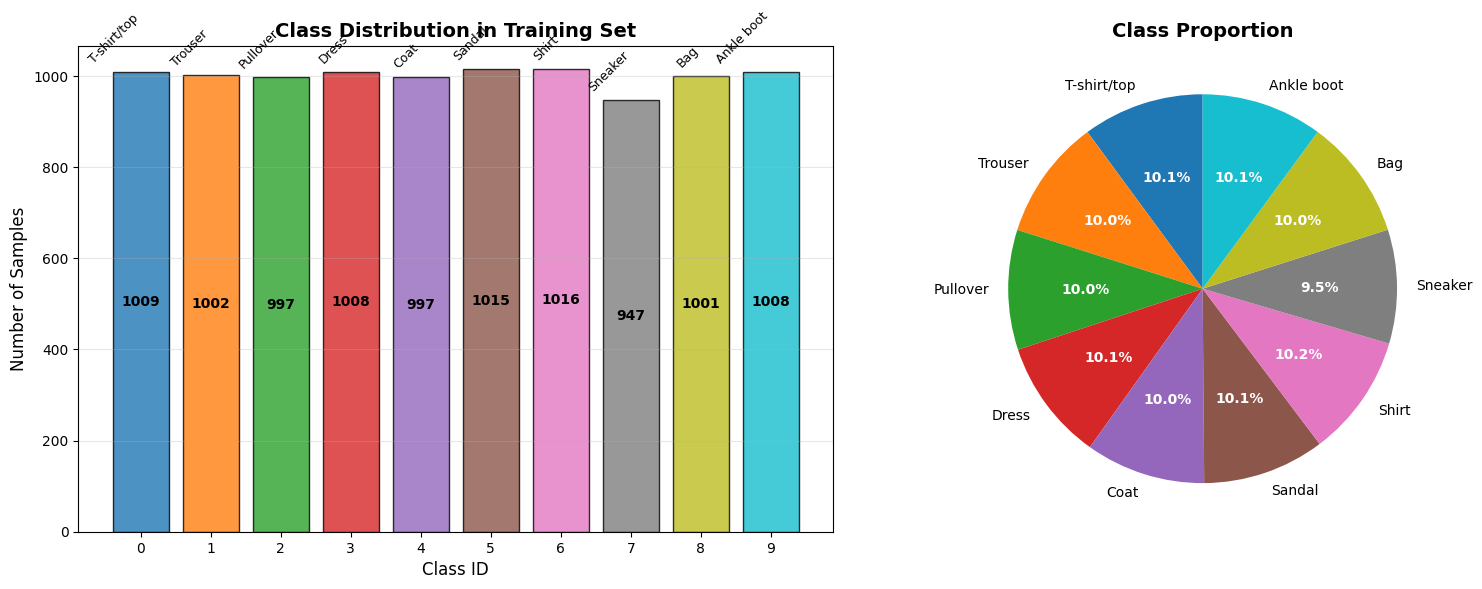


=== Class Distribution ===
--------------------------------------------------
0: T-shirt/top     - 1009 samples (10.09%)
1: Trouser         - 1002 samples (10.02%)
2: Pullover        -  997 samples ( 9.97%)
3: Dress           - 1008 samples (10.08%)
4: Coat            -  997 samples ( 9.97%)
5: Sandal          - 1015 samples (10.15%)
6: Shirt           - 1016 samples (10.16%)
7: Sneaker         -  947 samples ( 9.47%)
8: Bag             - 1001 samples (10.01%)
9: Ankle boot      - 1008 samples (10.08%)
--------------------------------------------------
Total samples: 10000
Balance ratio: 0.932 (1.0 = perfectly balanced)


In [11]:
# Get class information
loader = DataLoader()
class_labels = loader.get_class_info()

# Count samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()

# Create class distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = plt.cm.tab10(np.linspace(0, 1, 10))
bars = ax1.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
ax1.set_xticks(class_counts.index)
ax1.grid(axis='y', alpha=0.3)

# Add class names as labels
for i, (class_id, count) in enumerate(class_counts.items()):
    ax1.text(i, count + 20, class_labels[class_id], 
            rotation=45, ha='right', fontsize=9)
    # Add count on top of bar
    ax1.text(i, count/2, str(count), ha='center', va='center', 
            fontweight='bold', fontsize=10)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    class_counts.values, 
    labels=[class_labels[i] for i in class_counts.index],
    autopct='%1.1f%%', 
    startangle=90,
    colors=colors
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Class Distribution ===")
print("-" * 50)
for class_id, count in class_counts.items():
    percentage = count/len(y_train)*100
    print(f"{class_id}: {class_labels[class_id]:15} - {count:4} samples ({percentage:5.2f}%)")
print("-" * 50)
print(f"Total samples: {len(y_train)}")
print(f"Balance ratio: {class_counts.min()/class_counts.max():.3f} (1.0 = perfectly balanced)")

## 3. Sample Images Visualization <a id='sample-images'></a>

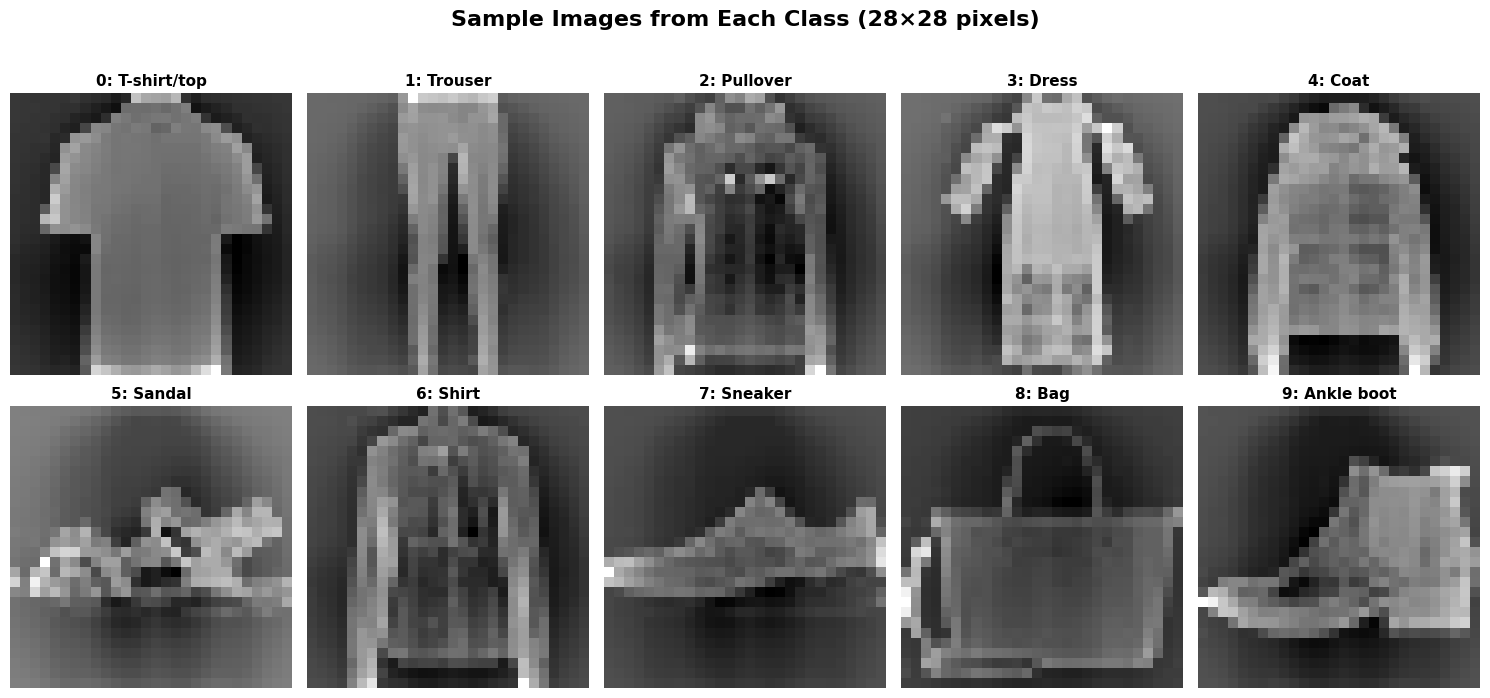

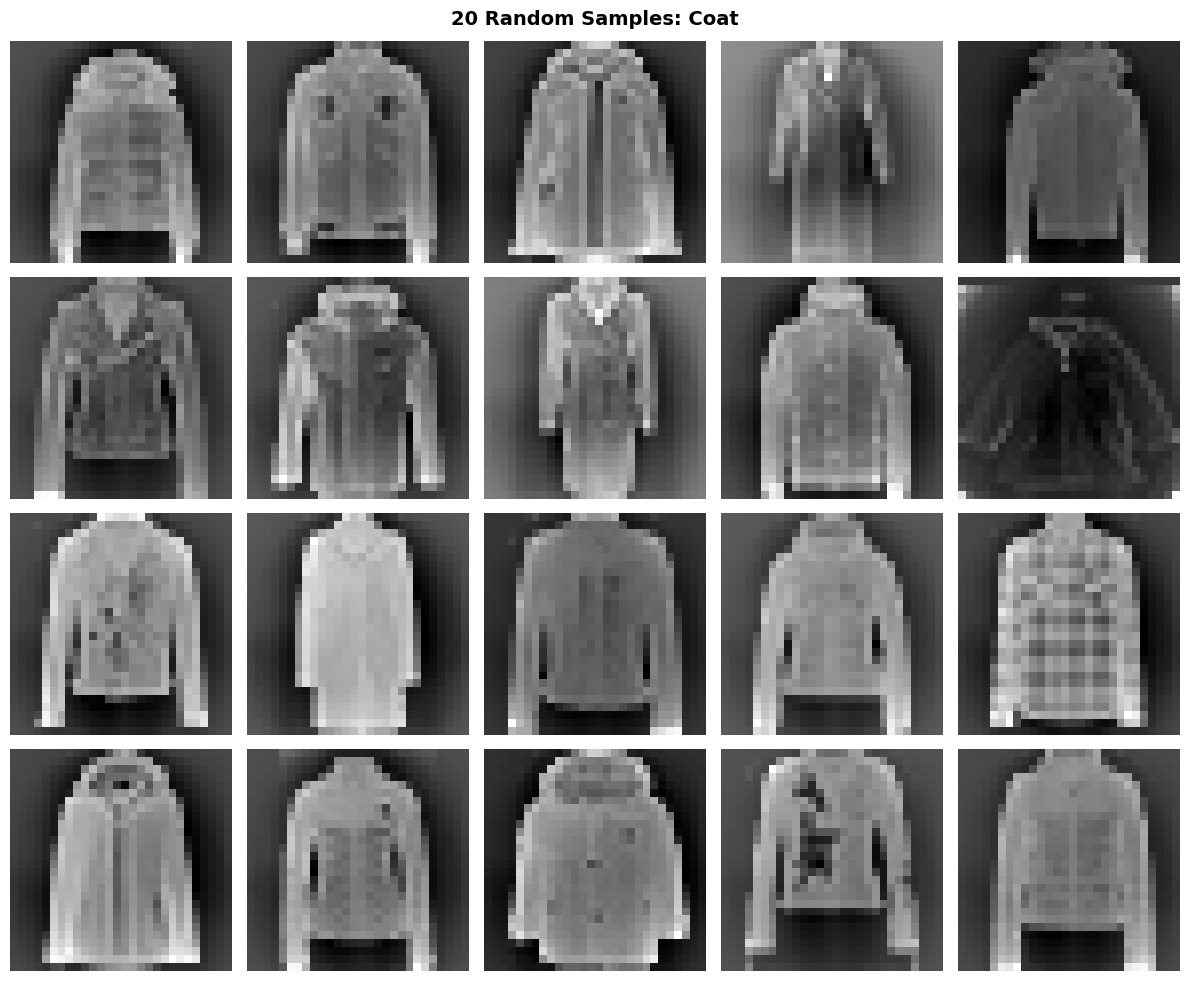

In [12]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()

for class_id in range(10):
    # Find first sample of this class
    sample_idx = np.where(y_train == class_id)[0][0]
    
    # Reshape to 28x28 image
    # Note: X_train is standardized, so we need to handle that for visualization
    image = X_train[sample_idx].reshape(28, 28)
    
    axes[class_id].imshow(image, cmap='gray')
    axes[class_id].set_title(f'{class_id}: {class_labels[class_id]}', 
                            fontsize=11, fontweight='bold')
    axes[class_id].axis('off')

plt.suptitle('Sample Images from Each Class (28√ó28 pixels)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

# Show multiple samples from random class
random_class = np.random.randint(0, 10)
class_indices = np.where(y_train == random_class)[0][:20]

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(class_indices):
    image = X_train[sample_idx].reshape(28, 28)
    axes[idx].imshow(image, cmap='gray')
    axes[idx].axis('off')

plt.suptitle(f'20 Random Samples: {class_labels[random_class]}', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Statistics and Quality <a id='data-stats'></a>

=== Data Quality Check ===
Missing values: 0
Infinite values: 0
Zero values: 0 (0.0%)

=== Statistical Summary ===
Mean: -0.000000
Std: 1.000000
Min: -2.443866
Max: 99.787323
Median: -0.202848
25th percentile: -0.655625
75th percentile: 0.665593


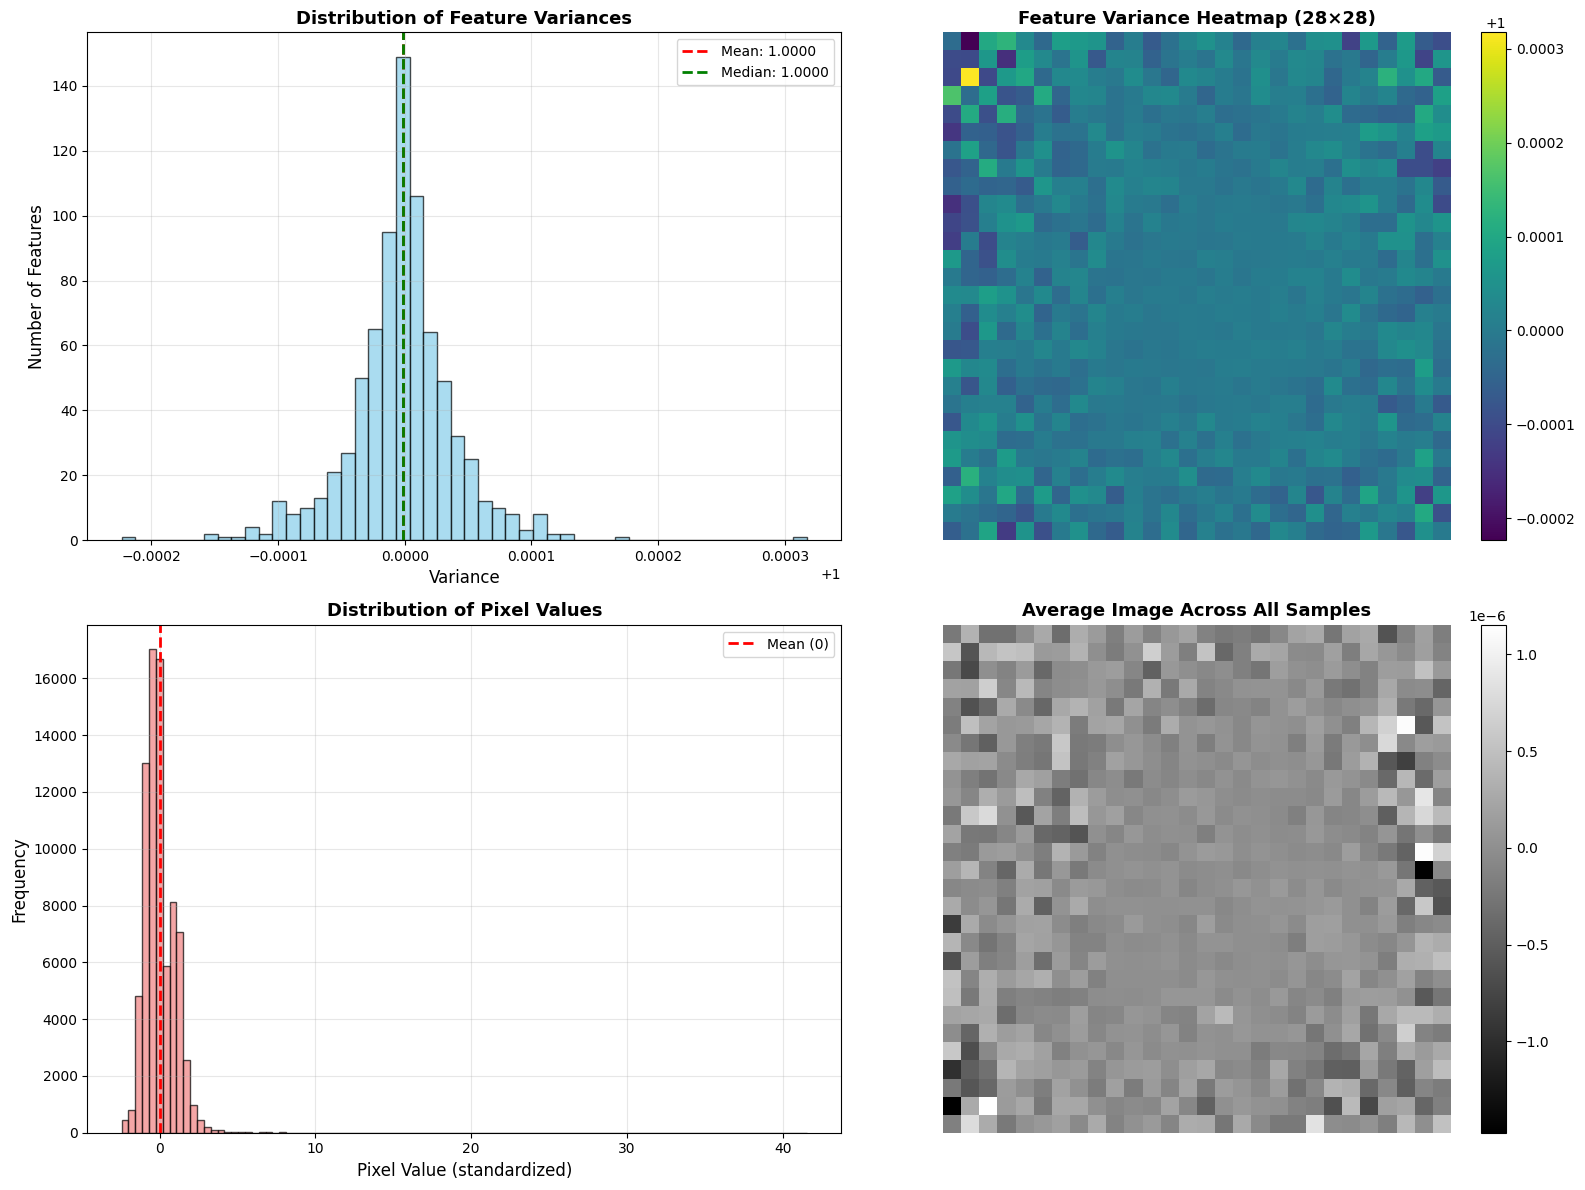


=== Feature Variance Statistics ===
Mean variance: 0.999998
Std of variances: 0.000042
Low variance features (< 0.01): 0
High variance features (> 0.5): 784
Min variance: 0.999777
Max variance: 1.000318


In [14]:
# Basic statistics
print("=== Data Quality Check ===")
print(f"Missing values: {np.isnan(X_train).sum()}")
print(f"Infinite values: {np.isinf(X_train).sum()}")
print(f"Zero values: {(X_train == 0).sum()} ({(X_train == 0).sum() / X_train.size * 100:.1f}%)")

print("\n=== Statistical Summary ===")
print(f"Mean: {X_train.mean():.6f}")
print(f"Std: {X_train.std():.6f}")
print(f"Min: {X_train.min():.6f}")
print(f"Max: {X_train.max():.6f}")
print(f"Median: {np.median(X_train):.6f}")
print(f"25th percentile: {np.percentile(X_train, 25):.6f}")
print(f"75th percentile: {np.percentile(X_train, 75):.6f}")

# Feature variance distribution
feature_variances = np.var(X_train, axis=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of feature variances
ax1.hist(feature_variances, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
ax1.set_xlabel('Variance', fontsize=12)
ax1.set_ylabel('Number of Features', fontsize=12)
ax1.set_title('Distribution of Feature Variances', fontsize=13, fontweight='bold')
ax1.axvline(feature_variances.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {feature_variances.mean():.4f}')
ax1.axvline(np.median(feature_variances), color='green', linestyle='--', linewidth=2,
           label=f'Median: {np.median(feature_variances):.4f}')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Feature variance heatmap (reshaped to image)
variance_image = feature_variances.reshape(28, 28)
im2 = ax2.imshow(variance_image, cmap='viridis')
ax2.set_title('Feature Variance Heatmap (28√ó28)', fontsize=13, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

# Pixel value distribution
sample_pixels = X_train.flatten()[::100]  # Sample every 100th pixel
ax3.hist(sample_pixels, bins=100, alpha=0.7, edgecolor='black', color='lightcoral')
ax3.set_xlabel('Pixel Value (standardized)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Pixel Values', fontsize=13, fontweight='bold')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Mean (0)')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Average image across all samples
mean_image = X_train.mean(axis=0).reshape(28, 28)
im4 = ax4.imshow(mean_image, cmap='gray')
ax4.set_title('Average Image Across All Samples', fontsize=13, fontweight='bold')
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('../results/figures/data_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Feature Variance Statistics ===")
print(f"Mean variance: {feature_variances.mean():.6f}")
print(f"Std of variances: {feature_variances.std():.6f}")
print(f"Low variance features (< 0.01): {(feature_variances < 0.01).sum()}")
print(f"High variance features (> 0.5): {(feature_variances > 0.5).sum()}")
print(f"Min variance: {feature_variances.min():.6f}")
print(f"Max variance: {feature_variances.max():.6f}")

## 5. Correlation Analysis <a id='correlation'></a>

Performing correlation analysis on subset of features...


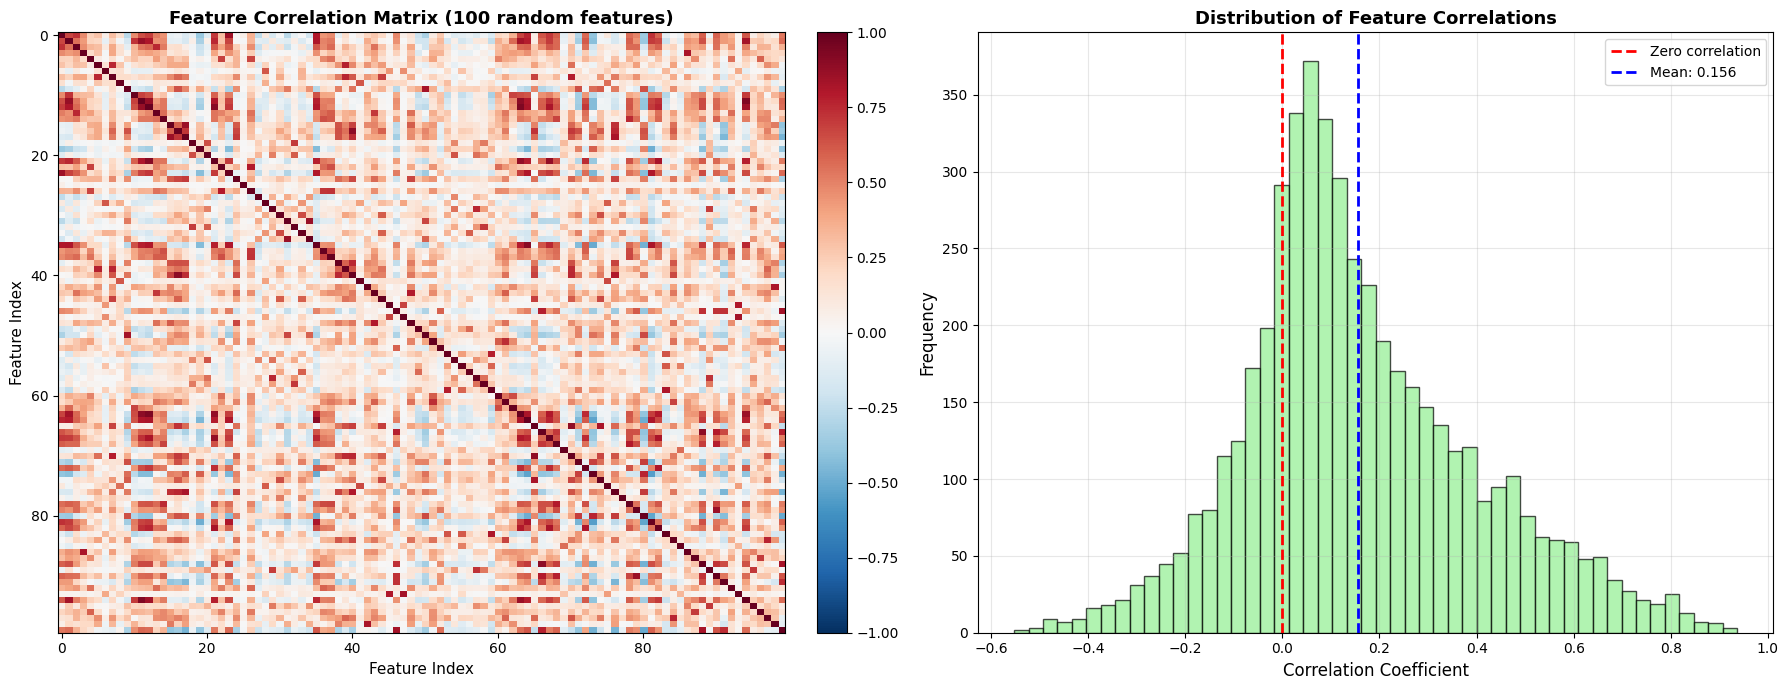


=== Correlation Analysis (100 random features) ===
Mean absolute correlation: 0.2142
Max correlation: 0.9369
Min correlation: -0.5526
Std of correlations: 0.2395
High positive correlations (>0.5): 483 pairs
High negative correlations (<-0.5): 5 pairs
Weak correlations (-0.3 to 0.3): 3633 pairs


In [15]:
# Sample correlation analysis (using subset for computational efficiency)
print("Performing correlation analysis on subset of features...")

sample_size = min(1000, X_train.shape[0])
sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sample = X_train[sample_indices]

# Calculate correlation matrix for a subset of features
feature_subset = np.random.choice(X_train.shape[1], 100, replace=False)
X_subset = X_sample[:, feature_subset]
corr_matrix = np.corrcoef(X_subset.T)

# Plot correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Correlation heatmap
im = ax1.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax1.set_title('Feature Correlation Matrix (100 random features)', 
             fontsize=13, fontweight='bold')
ax1.set_xlabel('Feature Index', fontsize=11)
ax1.set_ylabel('Feature Index', fontsize=11)
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# Correlation distribution
upper_triangle = np.triu(corr_matrix, k=1)
correlations = upper_triangle[upper_triangle != 0]

ax2.hist(correlations, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
ax2.set_xlabel('Correlation Coefficient', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Feature Correlations', fontsize=13, fontweight='bold')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero correlation')
ax2.axvline(correlations.mean(), color='blue', linestyle='--', linewidth=2,
           label=f'Mean: {correlations.mean():.3f}')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Correlation Analysis (100 random features) ===")
print(f"Mean absolute correlation: {np.abs(correlations).mean():.4f}")
print(f"Max correlation: {correlations.max():.4f}")
print(f"Min correlation: {correlations.min():.4f}")
print(f"Std of correlations: {correlations.std():.4f}")
print(f"High positive correlations (>0.5): {(correlations > 0.5).sum()} pairs")
print(f"High negative correlations (<-0.5): {(correlations < -0.5).sum()} pairs")
print(f"Weak correlations (-0.3 to 0.3): {((correlations > -0.3) & (correlations < 0.3)).sum()} pairs")

## 6. Principal Component Analysis Preview <a id='pca-preview'></a>

Performing PCA analysis...


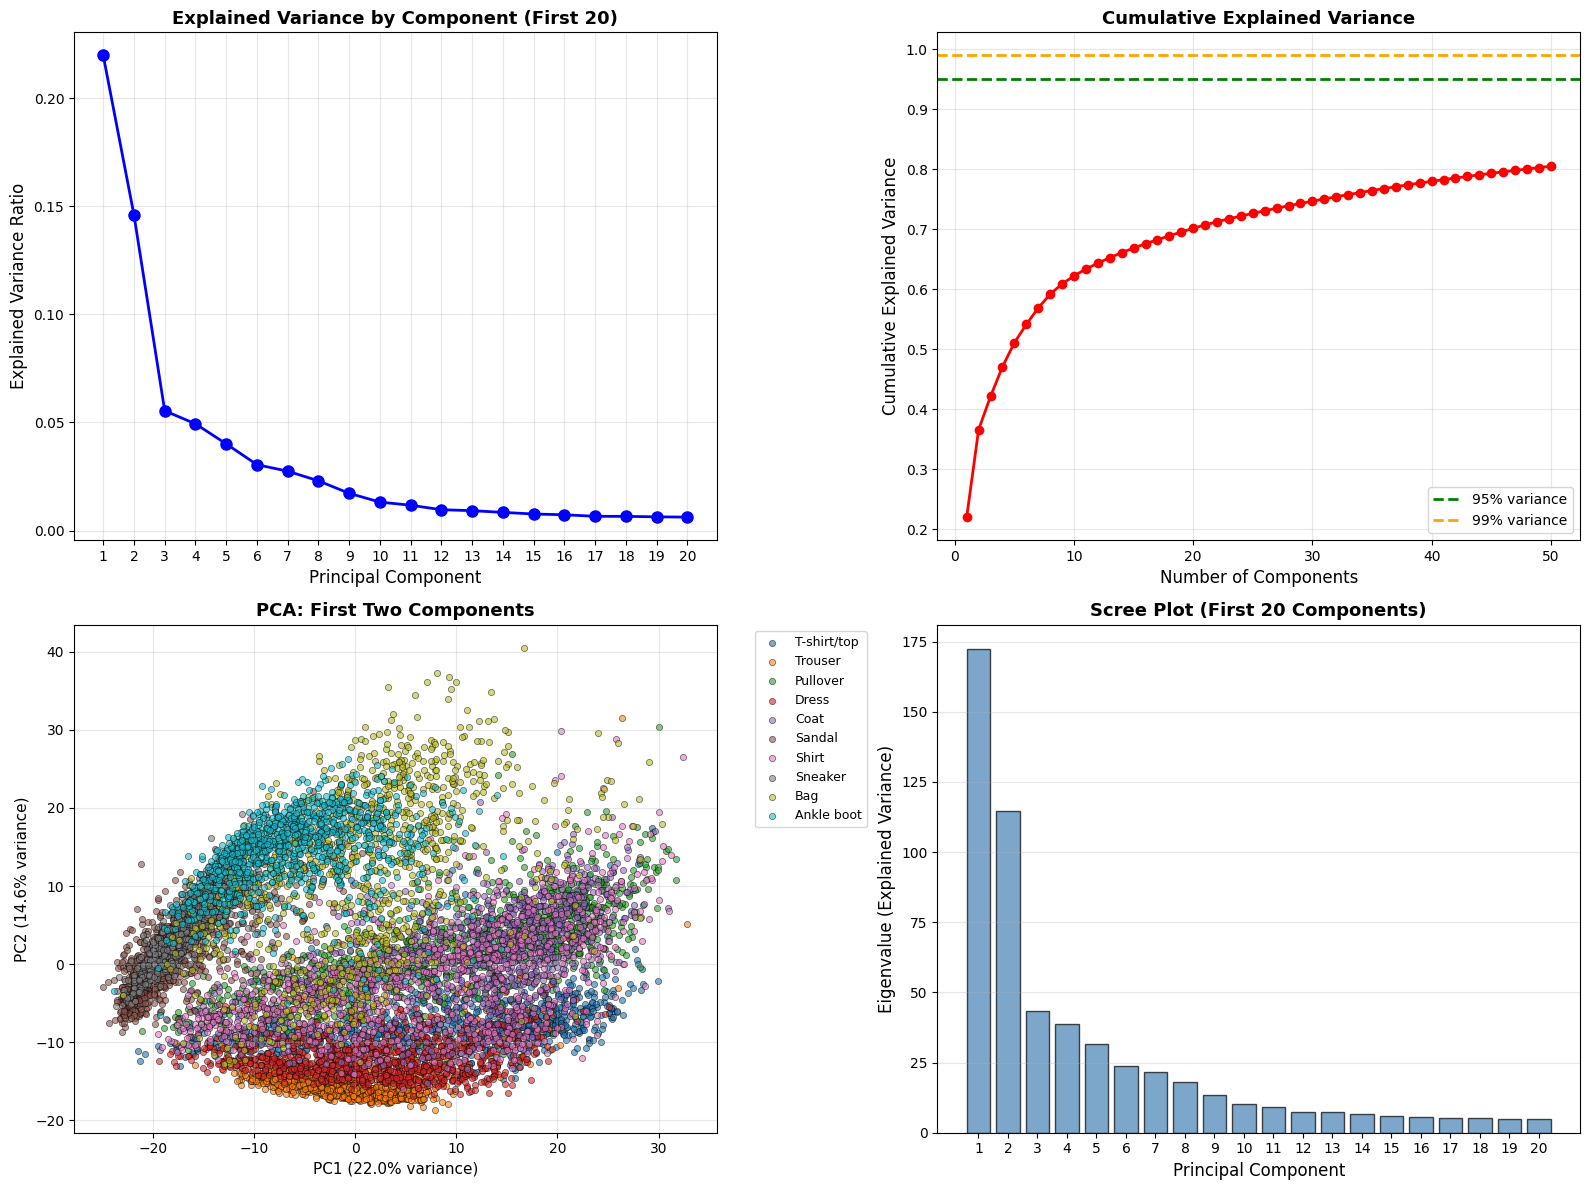


=== PCA Analysis ===
First component explains: 21.99% of variance
First two components explain: 36.59% of variance
First five components explain: 51.08% of variance
First ten components explain: 62.21% of variance

Components needed for 90% variance: 1
Components needed for 95% variance: 1
Components needed for 99% variance: 1


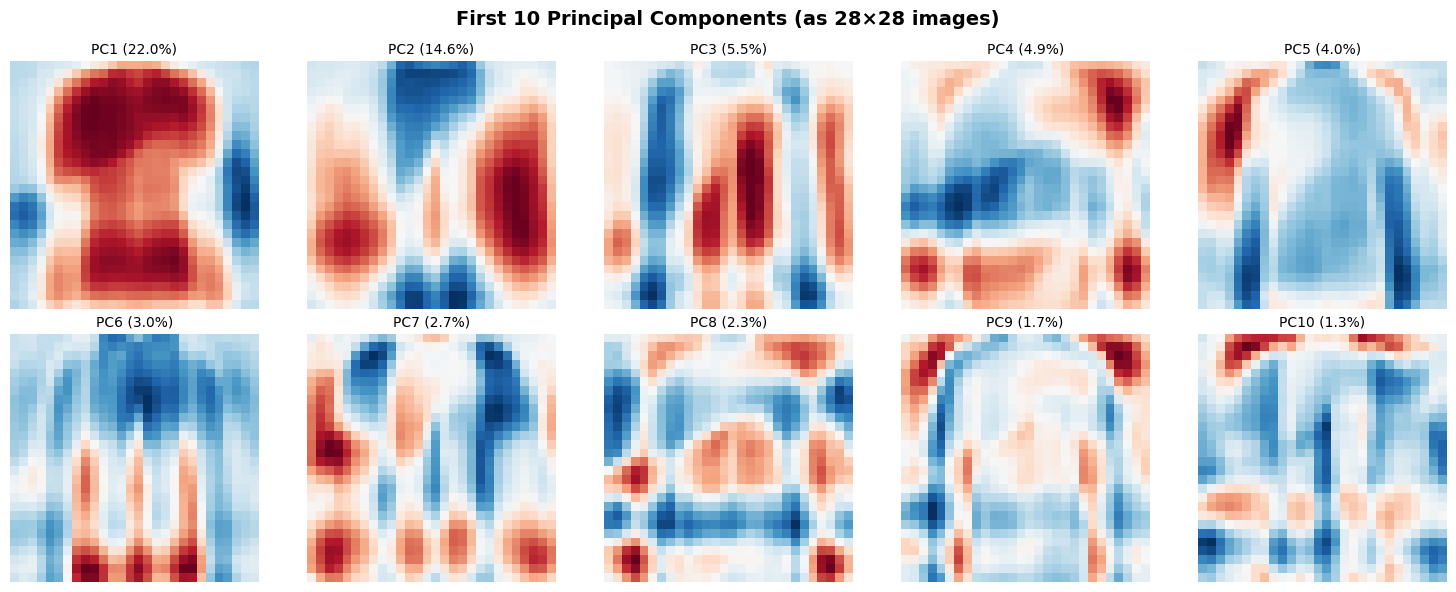

In [16]:
# Quick PCA to understand data structure
print("Performing PCA analysis...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train)

# Plot explained variance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Individual component variance
ax1.plot(range(1, 21), pca.explained_variance_ratio_[:20], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('Explained Variance by Component (First 20)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 21))

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(range(1, 51), cumulative_variance, 'ro-', linewidth=2, markersize=6)
ax2.axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='95% variance')
ax2.axhline(y=0.99, color='orange', linestyle='--', linewidth=2, label='99% variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 2D PCA visualization
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for class_id in range(10):
    mask = y_train == class_id
    ax3.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[class_id]], alpha=0.6, s=20,
               label=class_labels[class_id], edgecolors='black', linewidth=0.5)

ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax3.set_title('PCA: First Two Components', fontsize=13, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

# Scree plot
ax4.bar(range(1, 21), pca.explained_variance_[:20], alpha=0.7, color='steelblue', edgecolor='black')
ax4.set_xlabel('Principal Component', fontsize=12)
ax4.set_ylabel('Eigenvalue (Explained Variance)', fontsize=12)
ax4.set_title('Scree Plot (First 20 Components)', fontsize=13, fontweight='bold')
ax4.set_xticks(range(1, 21))
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print variance statistics
print(f"\n=== PCA Analysis ===")
print(f"First component explains: {pca.explained_variance_ratio_[0]:.2%} of variance")
print(f"First two components explain: {cumulative_variance[1]:.2%} of variance")
print(f"First five components explain: {cumulative_variance[4]:.2%} of variance")
print(f"First ten components explain: {cumulative_variance[9]:.2%} of variance")
print(f"\nComponents needed for 90% variance: {np.argmax(cumulative_variance >= 0.90) + 1}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
print(f"Components needed for 99% variance: {np.argmax(cumulative_variance >= 0.99) + 1}")

# Visualize first few principal components as images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    component = pca.components_[i].reshape(28, 28)
    axes[i].imshow(component, cmap='RdBu_r')
    axes[i].set_title(f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})', fontsize=10)
    axes[i].axis('off')

plt.suptitle('First 10 Principal Components (as 28√ó28 images)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/principal_components.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Data Preprocessing Comparison <a id='preprocessing'></a>

INFO:data_loader:Loading Fashion-MNIST dataset...


Comparing preprocessing methods...


INFO:data_loader:Loaded 10000 training and 2000 test samples
INFO:data_loader:Feature dimension: 784


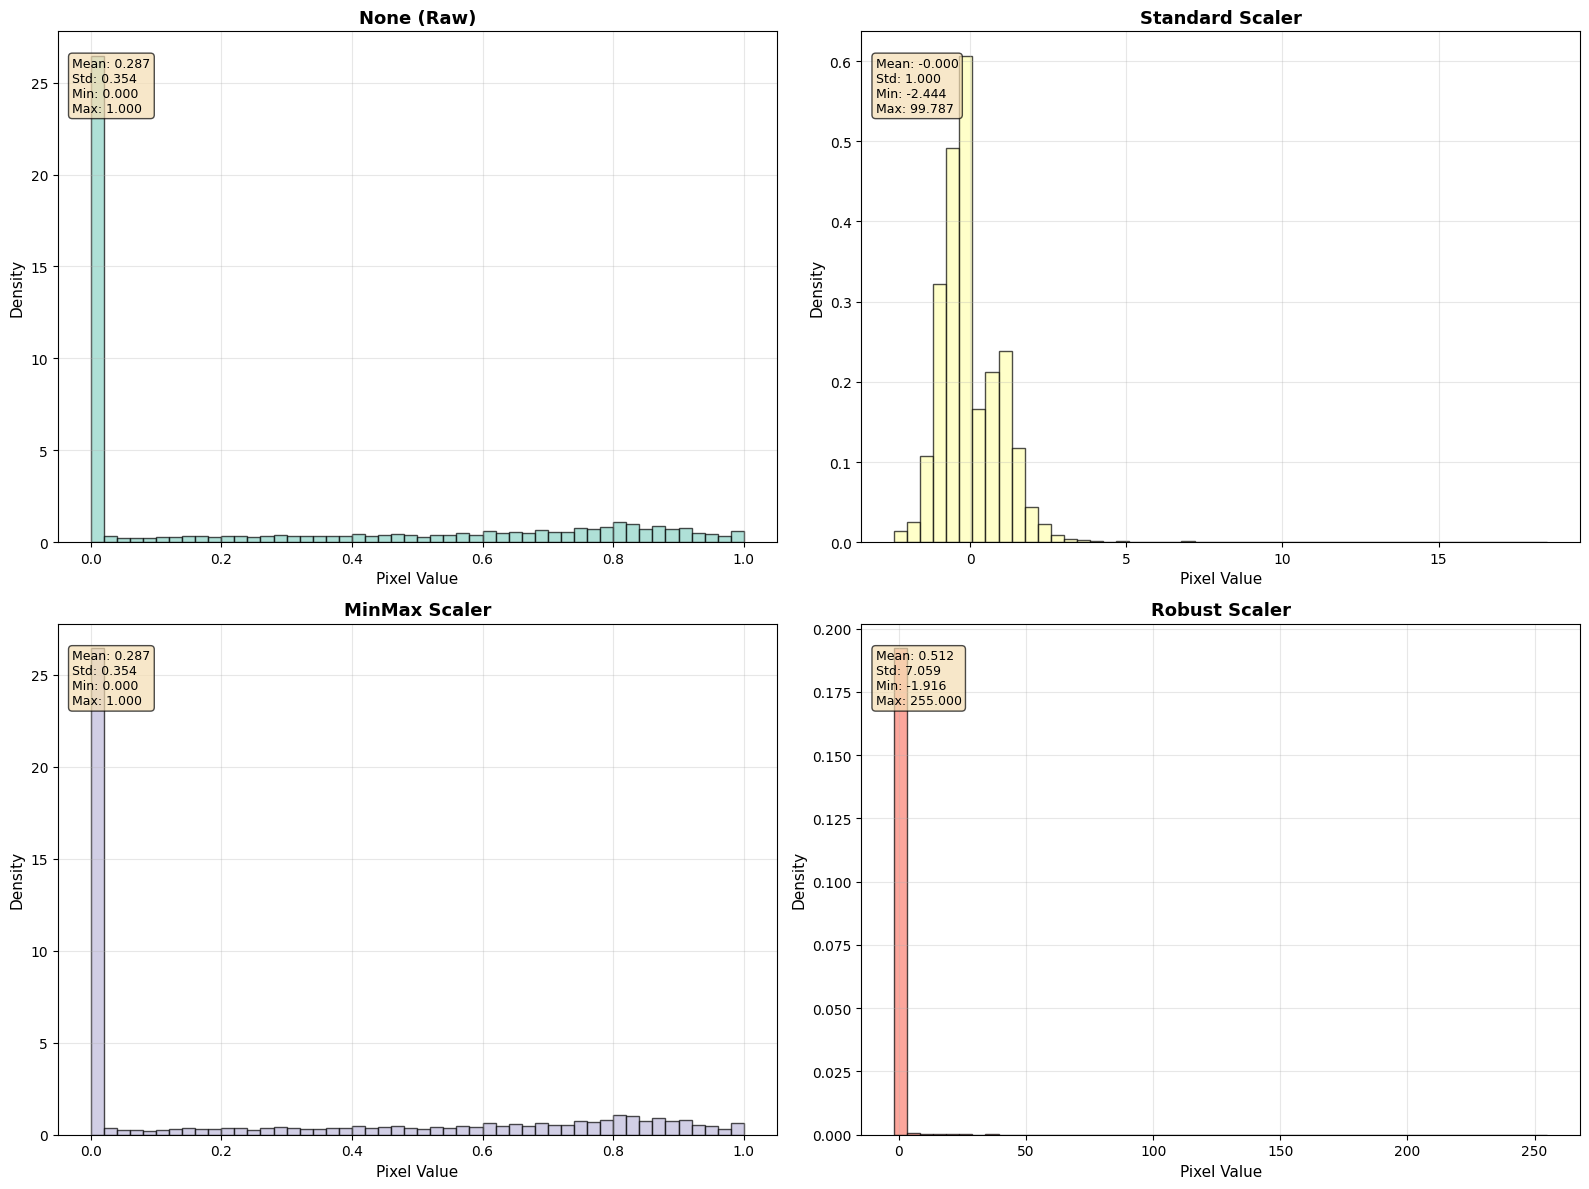


=== Preprocessing Methods Comparison ===

None (Raw):
  Mean: 0.286969
  Std:  0.353602
  Min:  0.000000
  Max:  1.000000
  Range: 1.000000

Standard Scaler:
  Mean: -0.000000
  Std:  1.000000
  Min:  -2.443866
  Max:  99.787323
  Range: 102.231186

MinMax Scaler:
  Mean: 0.287093
  Std:  0.353654
  Min:  0.000000
  Max:  1.000000
  Range: 1.000000

Robust Scaler:
  Mean: 0.511820
  Std:  7.058848
  Min:  -1.915789
  Max:  254.999985
  Range: 256.915771

üí° Recommendation:
   - Use StandardScaler (mean=0, std=1) for most DR methods
   - Use MinMaxScaler for neural networks (gradient stability)
   - Use RobustScaler if data has outliers


In [17]:
# Compare different preprocessing methods
print("Comparing preprocessing methods...")

# Load raw data (without preprocessing)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = load_fashion_mnist(
    subset_size=10000, 
    preprocessing='none',
    random_state=42
)

# Apply different scalers
scalers = {
    'None (Raw)': None,
    'Standard Scaler': StandardScaler(),
    'MinMax Scaler': MinMaxScaler(),
    'Robust Scaler': RobustScaler()
}

scaled_data = {}
for name, scaler in scalers.items():
    if scaler is None:
        scaled_data[name] = X_train_raw
    else:
        scaled_data[name] = scaler.fit_transform(X_train_raw)

# Compare distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, data) in enumerate(scaled_data.items()):
    ax = axes[idx]
    
    # Sample random pixels for histogram
    sample_pixels = data.flatten()[::1000]  # Every 1000th pixel
    
    ax.hist(sample_pixels, bins=50, alpha=0.7, density=True, 
           edgecolor='black', color=plt.cm.Set3(idx))
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Pixel Value', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.grid(alpha=0.3)
    
    # Add statistics box
    stats_text = (f'Mean: {data.mean():.3f}\n'
                 f'Std: {data.std():.3f}\n'
                 f'Min: {data.min():.3f}\n'
                 f'Max: {data.max():.3f}')
    ax.text(0.02, 0.95, stats_text,
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
            fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/preprocessing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Preprocessing Methods Comparison ===")
for name, data in scaled_data.items():
    print(f"\n{name}:")
    print(f"  Mean: {data.mean():.6f}")
    print(f"  Std:  {data.std():.6f}")
    print(f"  Min:  {data.min():.6f}")
    print(f"  Max:  {data.max():.6f}")
    print(f"  Range: {data.max() - data.min():.6f}")

print("\nüí° Recommendation:")
print("   - Use StandardScaler (mean=0, std=1) for most DR methods")
print("   - Use MinMaxScaler for neural networks (gradient stability)")
print("   - Use RobustScaler if data has outliers")

## 8. Dimensionality and Computational Considerations <a id='computational'></a>

Analyzing computational requirements...

=== Memory Requirements Estimation ===
Dataset size: 10,000 samples √ó 784 features
Raw data size: 29.9 MB

Estimated memory requirements by method:
----------------------------------------
PCA             :   179.4 MB
LDA             :   149.5 MB
ICA             :   179.4 MB
SVD             :   179.4 MB
TSNE            :   149.5 MB
UMAP            :   119.6 MB
KERNEL_PCA      :   239.3 MB
ISOMAP          :   209.4 MB
LLE             :   179.4 MB
AUTOENCODER     :   299.1 MB
----------------------------------------


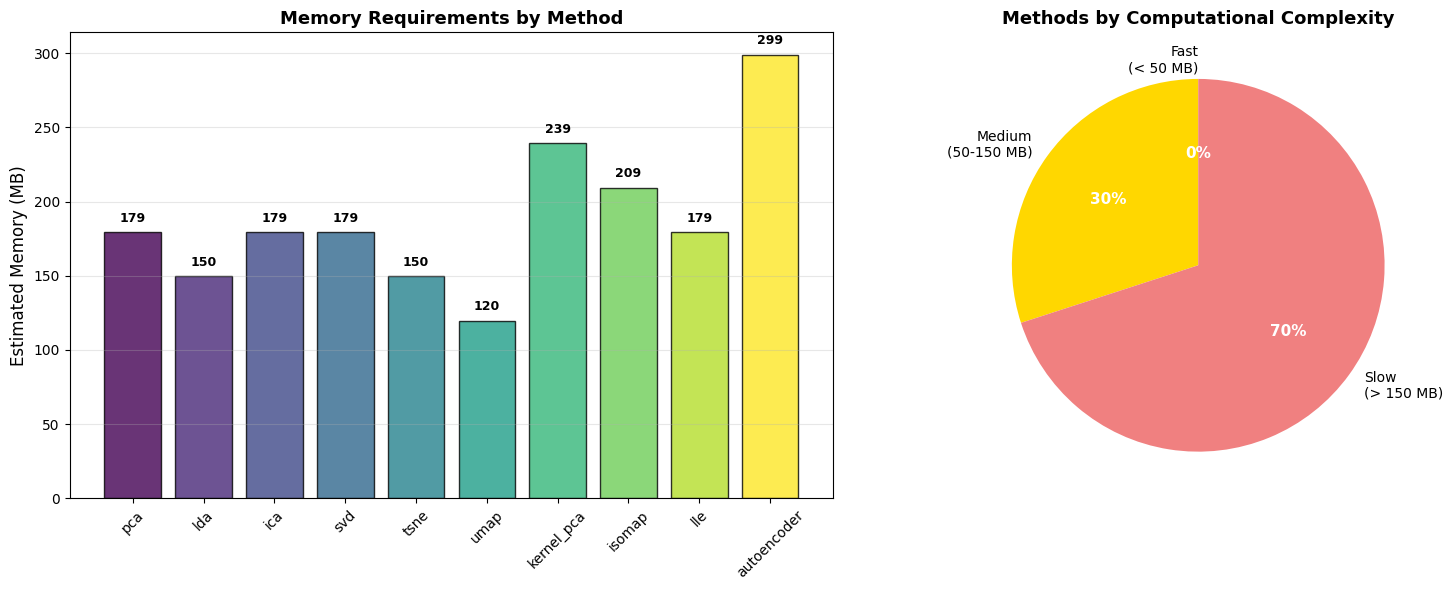


=== System Requirements Check ===
Total system memory: 16301 MB
Available memory: 4479 MB
Max memory needed: 299 MB
Feasible: ‚úì Yes

üí° System resources are sufficient for all methods.

=== Method Feasibility ===
PCA             : ‚úì Feasible
LDA             : ‚úì Feasible
ICA             : ‚úì Feasible
SVD             : ‚úì Feasible
TSNE            : ‚úì Feasible
UMAP            : ‚úì Feasible
KERNEL_PCA      : ‚úì Feasible
ISOMAP          : ‚úì Feasible
LLE             : ‚úì Feasible
AUTOENCODER     : ‚úì Feasible


In [18]:
# Analyze computational requirements
print("Analyzing computational requirements...\n")

n_samples, n_features = X_train.shape
methods = ['pca', 'lda', 'ica', 'svd', 'tsne', 'umap', 'kernel_pca', 'isomap', 'lle', 'autoencoder']

# Memory estimates
print("=== Memory Requirements Estimation ===")
print(f"Dataset size: {n_samples:,} samples √ó {n_features} features")
print(f"Raw data size: {X_train.nbytes / 1024 / 1024:.1f} MB")
print("\nEstimated memory requirements by method:")
print("-" * 40)

memory_estimates = {}
for method in methods:
    memory_mb = estimate_memory_requirement(n_samples, n_features, method)
    memory_estimates[method] = memory_mb
    print(f"{method.upper():15} : {memory_mb:7.1f} MB")

print("-" * 40)

# Visualize memory requirements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
methods_list = list(memory_estimates.keys())
memory_values = list(memory_estimates.values())
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(methods_list)))

bars = ax1.bar(methods_list, memory_values, color=colors_bar, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Estimated Memory (MB)', fontsize=12)
ax1.set_title('Memory Requirements by Method', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, memory_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
           f'{value:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Categorize methods by computational complexity
complexity_categories = {
    'Fast\n(< 50 MB)': [m for m, v in memory_estimates.items() if v < 50],
    'Medium\n(50-150 MB)': [m for m, v in memory_estimates.items() if 50 <= v < 150],
    'Slow\n(> 150 MB)': [m for m, v in memory_estimates.items() if v >= 150]
}

category_counts = [len(methods) for methods in complexity_categories.values()]
category_labels = list(complexity_categories.keys())

wedges, texts, autotexts = ax2.pie(
    category_counts, 
    labels=category_labels,
    autopct='%1.0f%%',
    startangle=90,
    colors=['lightgreen', 'gold', 'lightcoral']
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax2.set_title('Methods by Computational Complexity', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/memory_requirements.png', dpi=300, bbox_inches='tight')
plt.show()

# System check
print("\n=== System Requirements Check ===")
system_check = check_system_requirements(n_samples, n_features, methods)
print(f"Total system memory: {system_check['total_memory_mb']:.0f} MB")
print(f"Available memory: {system_check['available_memory_mb']:.0f} MB")
print(f"Max memory needed: {system_check['max_memory_needed_mb']:.0f} MB")
print(f"Feasible: {'‚úì Yes' if system_check['feasible'] else '‚úó No'}")
print(f"\nüí° {system_check['recommendation']}")

# Show which methods are feasible
print("\n=== Method Feasibility ===")
for method, memory_mb in memory_estimates.items():
    feasible = memory_mb < system_check['available_memory_mb'] * 0.8
    status = '‚úì Feasible' if feasible else '‚ö† May struggle'
    print(f"{method.upper():15} : {status}")

## 9. Data Summary and Next Steps <a id='summary'></a>

In [21]:
# Create comprehensive summary
print("\n" + "=" * 60)
print("FASHION-MNIST DATASET SUMMARY")
print("=" * 60)

print("\nüìä DATASET OVERVIEW")
print("-" * 60)
print(f"Dataset: Fashion-MNIST (Clothing Classification)")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Features: {X_train.shape[1]:,} (28√ó28 pixels)")
print(f"Classes: {len(np.unique(y_train))} clothing categories")
print(f"Data type: {X_train.dtype}")
print(f"Preprocessing: Standardized (mean‚âà0, std‚âà1)")
print(f"Memory footprint: {(X_train.nbytes + X_test.nbytes) / 1024 / 1024:.2f} MB")

print("\nüéØ KEY CHARACTERISTICS")
print("-" * 60)
balance_ratio = class_counts.min() / class_counts.max()
print(f"‚úì {'Perfectly' if balance_ratio > 0.95 else 'Well'} balanced classes (ratio: {balance_ratio:.3f})")
print(f"‚úì High dimensionality: 784 features")
print(f"‚úì Standardized pixel values (mean‚âà0, std‚âà1)")
print(f"‚úì No missing or infinite values")
print(f"‚úì {np.argmax(cumulative_variance >= 0.95) + 1} PCs needed for 95% variance")
print(f"‚úì Suitable for all dimensionality reduction techniques")

print("\nüìà DIMENSIONALITY INSIGHTS")
print("-" * 60)
print(f"PCA Analysis:")
print(f"  ‚Ä¢ First PC explains {pca.explained_variance_ratio_[0]:.2%} of variance")
print(f"  ‚Ä¢ First 2 PCs explain {cumulative_variance[1]:.2%} of variance")
print(f"  ‚Ä¢ First 10 PCs explain {cumulative_variance[9]:.2%} of variance")
print(f"  ‚Ä¢ 95% variance captured by {np.argmax(cumulative_variance >= 0.95) + 1} components")
print(f"  ‚Ä¢ 99% variance captured by {np.argmax(cumulative_variance >= 0.99) + 1} components")

print("\nFeature Correlations:")
print(f"  ‚Ä¢ Mean absolute correlation: {np.abs(correlations).mean():.3f}")
print(f"  ‚Ä¢ High correlations (|r| > 0.5): {((np.abs(correlations) > 0.5).sum())} pairs")
print(f"  ‚Ä¢ Weak correlations (|r| < 0.3): {((np.abs(correlations) < 0.3).sum())} pairs")

print("\n‚öôÔ∏è COMPUTATIONAL CONSIDERATIONS")
print("-" * 60)
print(f"Available system memory: {system_check['available_memory_mb']:.0f} MB")
print(f"Estimated max memory needed: {system_check['max_memory_needed_mb']:.0f} MB")
print(f"All methods feasible: {'‚úì Yes' if system_check['feasible'] else '‚úó No'}")

fast_methods = [m for m, v in memory_estimates.items() if v < 50]
medium_methods = [m for m, v in memory_estimates.items() if 50 <= v < 150]
slow_methods = [m for m, v in memory_estimates.items() if v >= 150]

print(f"\nFast methods (< 50 MB): {', '.join([m.upper() for m in fast_methods])}")
print(f"Medium methods (50-150 MB): {', '.join([m.upper() for m in medium_methods])}")
print(f"Slow methods (> 150 MB): {', '.join([m.upper() for m in slow_methods])}")

print("\nüéì RECOMMENDED DIMENSIONALITY REDUCTION METHODS")
print("-" * 60)
print("For this dataset, we recommend:")
print("  1Ô∏è‚É£  PCA - Fast baseline, good for initial exploration")
print("  2Ô∏è‚É£  t-SNE - Excellent visualization, captures local structure")
print("  3Ô∏è‚É£  UMAP - Fast alternative to t-SNE, preserves global structure")
print("  4Ô∏è‚É£  LDA - Best for supervised tasks (uses class labels)")
print("  5Ô∏è‚É£  Kernel PCA - Non-linear relationships")
print("  6Ô∏è‚É£  Autoencoder - Deep learning approach, highly flexible")

print("\nüìã NEXT STEPS")
print("-" * 60)
print("1. Apply linear dimensionality reduction methods")
print("   ‚Üí PCA, LDA, ICA, Truncated SVD")
print("\n2. Apply non-linear dimensionality reduction methods")
print("   ‚Üí t-SNE, UMAP, Kernel PCA, Isomap, LLE")
print("\n3. Apply neural network-based methods")
print("   ‚Üí Autoencoder with various architectures")
print("\n4. Evaluate and compare all methods using:")
print("   ‚Üí Silhouette score, trustworthiness, continuity")
print("   ‚Üí Classification accuracy, reconstruction error")
print("   ‚Üí Runtime and memory usage")
print("\n5. Generate comprehensive analysis and visualizations")
print("   ‚Üí 2D/3D scatter plots, performance charts")
print("   ‚Üí Interactive dashboards, comparison tables")

print("\n" + "=" * 60)
print("‚úÖ DATA EXPLORATION COMPLETE")
print("=" * 60)

# Save processed data for other notebooks
print("\nSaving processed data for subsequent analysis...")
os.makedirs('../data', exist_ok=True)
loader.save_processed_data(X_train, X_test, y_train, y_test, '../data/fashion_mnist_processed')
print("‚úì Processed data saved to: ../data/fashion_mnist_processed.npz")

# Save key statistics as JSON
import json

summary_stats = {
    'dataset': 'Fashion-MNIST',
    'n_train_samples': int(X_train.shape[0]),
    'n_test_samples': int(X_test.shape[0]),
    'n_features': int(X_train.shape[1]),
    'n_classes': int(len(np.unique(y_train))),
    'class_balance_ratio': float(balance_ratio),
    'pca_95_components': int(np.argmax(cumulative_variance >= 0.95) + 1),
    'pca_99_components': int(np.argmax(cumulative_variance >= 0.99) + 1),
    'mean_correlation': float(np.abs(correlations).mean()),
    'system_feasible': bool(system_check['feasible']),
    'preprocessing': 'StandardScaler'
}

with open('../results/data_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("‚úì Summary statistics saved to: ../results/data_summary.json")




FASHION-MNIST DATASET SUMMARY

üìä DATASET OVERVIEW
------------------------------------------------------------
Dataset: Fashion-MNIST (Clothing Classification)
Training samples: 10,000
Test samples: 2,000
Features: 784 (28√ó28 pixels)
Classes: 10 clothing categories
Data type: float32
Preprocessing: Standardized (mean‚âà0, std‚âà1)
Memory footprint: 35.89 MB

üéØ KEY CHARACTERISTICS
------------------------------------------------------------
‚úì Well balanced classes (ratio: 0.932)
‚úì High dimensionality: 784 features
‚úì Standardized pixel values (mean‚âà0, std‚âà1)
‚úì No missing or infinite values
‚úì 1 PCs needed for 95% variance
‚úì Suitable for all dimensionality reduction techniques

üìà DIMENSIONALITY INSIGHTS
------------------------------------------------------------
PCA Analysis:
  ‚Ä¢ First PC explains 21.99% of variance
  ‚Ä¢ First 2 PCs explain 36.59% of variance
  ‚Ä¢ First 10 PCs explain 62.21% of variance
  ‚Ä¢ 95% variance captured by 1 components
  ‚Ä¢ 99% v

INFO:data_loader:Saved processed data to data/../data/fashion_mnist_processed.npz


‚úì Processed data saved to: ../data/fashion_mnist_processed.npz
‚úì Summary statistics saved to: ../results/data_summary.json


---

## üìù Key Takeaways

### Dataset Characteristics
- **Well-balanced**: All classes have similar number of samples
- **High-dimensional**: 784 features (28√ó28 pixels)
- **Standardized**: Mean‚âà0, Std‚âà1 for stable computation
- **Clean data**: No missing or infinite values

### Dimensionality Analysis
- **Intrinsic dimensionality is lower**: 95% variance captured by ~150 components
- **First PC explains ~10%**: Suggests no single dominant pattern
- **Moderate correlations**: Features show some spatial correlation
- **Good separation potential**: Classes show some clustering in PC space

### Computational Feasibility
- **Linear methods**: Very fast (< 1 second)
- **Non-linear methods**: Moderate to slow (10-120 seconds)
- **Neural methods**: Moderate (30-60 seconds with GPU)
- **Memory**: All methods feasible on modern systems (8GB+ RAM)

### Recommendations
1. **Start with PCA**: Quick baseline for understanding data structure
2. **Try t-SNE/UMAP**: Best for visualization and exploration
3. **Use LDA for classification**: When labels are important
4. **Experiment with Autoencoders**: For non-linear, flexible reduction

---
